In [1]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import hamming_loss
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
def generate_dataset():

    print("Generating dataset...")

    data = sklearn.datasets.fetch_20newsgroups_vectorized(subset='all')

    X, y = csr_matrix(data.data), np.array(data.target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    gc.collect()

    print("Dataset generated.")

    return X_train, y_train, X_test, y_test

In [3]:
def build_and_predict(model,
                        X_train, y_train, X_test, y_test,
                        complexity_fn):
    
    model.fit(X_train, y_train)

    start = time.time()
    y_pred = model.predict(X_test)
    prediction_latency = time.time() - start

    complexity = complexity_fn(model)

    performance_score = hamming_loss(y_test, y_pred)

    return [complexity, prediction_latency, performance_score]

In [4]:
X_train, y_train, X_test, y_test = generate_dataset()

Generating dataset...
Dataset generated.


In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15076, 130107), (15076,), (3770, 130107), (3770,))

In [6]:
sgd_classifier = SGDClassifier(penalty='elasticnet', alpha=0.001, tol=1e-1)

def _count_nonzero_coefficients(estimator):
    return np.count_nonzero(estimator.coef_)

In [7]:
build_and_predict(sgd_classifier, X_train, y_train, X_test, y_test, _count_nonzero_coefficients)

[2472, 0.03566551208496094, 0.2946949602122016]

In [24]:
def plot_model_details(performance_details):

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(right=0.75)

    plt.plot(
        [row[0] for row in performance_details],
        [row[1] for row in performance_details],
        label='Prediction latency (s)'
    )

    plt.plot(
        [row[0] for row in performance_details],
        [row[2] for row in performance_details],
        label='Performance score'
    )
    plt.xlabel('Complexity')
    plt.legend(loc='best');

In [13]:
model_perf = {}

In [14]:
l1_ratios = [0.25, 0.5, 0.75, 0.9]

model_perf['sgd'] = []

for ratio in l1_ratios:

    sgd_classifier = SGDClassifier(penalty='elasticnet', alpha=0.001, tol=1e-1, l1_ratio=ratio)
    performance_details = build_and_predict(
        sgd_classifier, X_train, y_train, X_test, y_test, _count_nonzero_coefficients
    )
    model_perf['sgd'].append(performance_details)

In [15]:
model_perf['sgd']

[[810, 0.022999286651611328, 0.33315649867374003],
 [193, 0.021996736526489258, 0.470026525198939],
 [80, 0.02595353126525879, 0.5819628647214854],
 [45, 0.023997783660888672, 0.6058355437665782]]

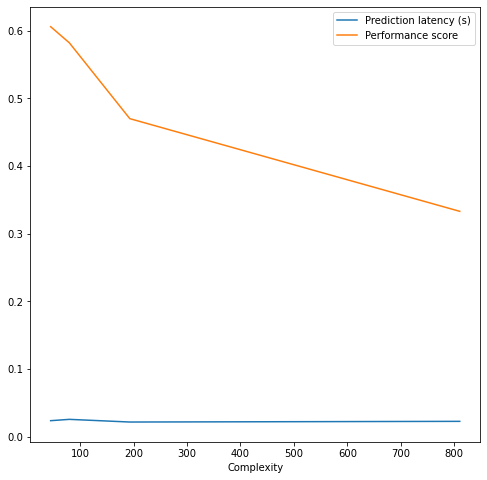

In [25]:
plot_model_details(model_perf['sgd'])

In [22]:
def _num_estimators(estimator):
    return estimator.n_estimators

In [23]:
n_estimators = [3, 5, 8, 10, 12]

model_perf['gbc'] = []

for n_est in n_estimators:

    gbc = GradientBoostingClassifier(n_estimators=n_est)
    performance_details = build_and_predict(
        gbc, X_train, y_train, X_test, y_test, _num_estimators
    )
    model_perf['gbc'].append(performance_details)
    print(f'Training {n_est} estimators completed...')

Training 3 estimators completed...
Training 5 estimators completed...
Training 8 estimators completed...
Training 10 estimators completed...
Training 12 estimators completed...


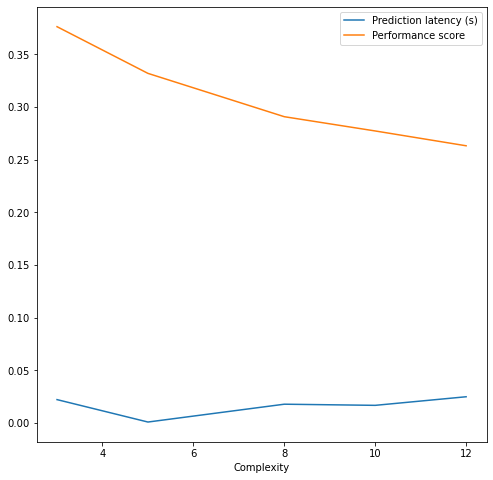

In [26]:
plot_model_details(model_perf['gbc'])

In [27]:
gc.collect()

17247